In [1]:
!pip install opencv-python

In [2]:
!pip install grad-cam torchcam

In [3]:
!pip install numpy==1.24.4

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import seaborn as sns
from torchvision.utils import make_grid
import cv2
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

DL involves randomness everywhere:
- Neural networks start with random weights
- DataLoader shuffles training data
- Data augmentation with random crops, flips...
- **CUDA operations**: some randomness happens on the GPU

Device
- If GPU is available, then leverage it when possible as it can significantly speedup DL training.

In [5]:
torch.manual_seed(42) # for the CPU
if torch.cuda.is_available(): # for the GPU
    torch.cuda.manual_seed(42)

# Define device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


## Data Preprocessing
#### Loading and Transformation
- transforms.Compose: Chains multiple transformations together.
- Augmentation
  - crop: specify a randomly crop region and the number of padding pixels. Helps simulate different views of an image.
  - flip: flip image direction. Helps the model learn position-invariant features.
  - color jitter: Adjusts brightness, contrast, and saturation randomly, preventinh overfitting by simulating different lighting conditions
- Converts images to a PyTorch tensor: C(color: RGB) × H(height) × W(width), where C=3, H=32, W=32
  - otherwise, the image format would be PIL or in Numpy Array (WxHxC), but the tensor format is (CxHxW)
- Normalization: Normalizes each RGB channel by specified mean and stdv, so that pixel values are in a defined range that helps stabilize and speed up training.
- Loaders - Batching, Shuffling, Parallel Loading
  - Batch size: Instead of training on the whole dataset, we use the mini-batches (128 images per batch) to achieve efficiency and stability, and avoid overfitting.
  - Shuffle: to avoid model remember te order of those pixels
  - number of workers: how many CPU are going to run the training

In [6]:
def get_dataloaders(batch_size = 128, dataset = 'cifar10'):

    transform_train = transforms.Compose([
      transforms.RandomCrop(32, padding=4),
      transforms.RandomHorizontalFlip(), # 50% of flipping
      transforms.ColorJitter(brightness = 0.2, contrast = 0.2, saturation = 0.2),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # mean for three channels, stdv for three channels
      ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    if dataset == 'cifar10':

        trainset = torchvision.datasets.CIFAR10(root = './data', train = True, download = True, transform = transform_train)
        testset = torchvision.datasets.CIFAR10(root = './data', train = False, download = True, transform = transform_test)
        num_classes = 10
        classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    else:  # cifar100
        trainset = torchvision.datasets.CIFAR100(root = './data', train = True, download = True, transform = transform_train)
        testset = torchvision.datasets.CIFAR100(root = './data', train = False, download = True, transform = transform_test)
        num_classes = 100
        classes = trainset.classes

    # validation dataset (10% of training data)
    num_train = len(trainset)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(0.1 * num_train))
    train_idx, valid_idx = indices[split: ], indices[ :split]

    # Create samplers
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    # Create data loaders
    train_loader = DataLoader(trainset, batch_size = batch_size, sampler = train_sampler)
    valid_loader = DataLoader(trainset, batch_size = batch_size, sampler = valid_sampler)
    test_loader = DataLoader(testset, batch_size=batch_size)

    return train_loader, valid_loader, test_loader, classes, num_classes, testset


#### One-Hot Encoding

Note: using one-hot encoding MSE or BCE loss. if we're using cross entropy loss, we should use integer class indices.

In [7]:
def one_hot_encode(labels, num_classes):
    one_hot = torch.zeros(labels.size(0), num_classes).to(labels.device)
    one_hot = one_hot.scatter_(1, labels.unsqueeze(1), 1.0)
    return one_hot

## Design a CNN Architecture
#### **ResidualBlock**

In very deep networks, training can become unstable, and the network might struggle to learn effectively. The shortcut connection helps by allowing the network to "remember" the original input, making it easier to learn small changes or adjustments.

To make the network easier to train and fight vanishing gradient problem, skipping some layers and allowing some original input go directly into output.

1. First Convolution: a 3x3 filter to the input to extract edges, textures...
  - Batch normalization: Helps the model train faster and more stable by normalizing outputs of conv1.
  - LeakyReLU: gives small non-zero output for negative inputs to introduce non-linearity so the network can learn complex patterns(fixes dying ReLU problem).
2. Second Convolution: another 3x3 filter to further refine the features.
3. Shortcut Connection
4. forward: where the data through the block

#### **CNN model**

1. Initial convolution

  Take raw image, applying a 3x3 filter to start extracting features like edges, colors...

2. Residual blocks
  
  Each layer processes the data further, extracting more complex features
  - Layer1: edges, corners
  - Layer2: textures
  - Layer3: object parts (eyes, wings)
  - Layer4: full object concepts (dog, truck)

3. Global Average Pooling & Classifier
  - AdaptiveAvgPool: squeezes each feature map into a single number. This simplifies the data and prepares it for the final classification step.
  - Dropout: to prevent overfitting, randomly disables some neurons
  - Fully connected layer (fc): turns the features into actual class scores


4. Weight Initialization (Kaiming initialization)

  Kaiming initialization is specifically designed for ReLU-based networks. it helps the network learn faster and more stably.

5. Helper Function: _make_layer()

  - Builds a chain of ResidualBlocks.
  - The first block might shrink the image (if stride = 2).
  - The rest just stack on top without changing size.

6. Forward Pass

  - image goes thru pipeline: conv1 -> layer1 -> layer2 -> layer3 -> layer4 -> avg_pool -> fc
  - Collecting intermediate features along the way

In [8]:
class ResidualBlock(nn.Module):

    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False) # 3x3 convolution filter, learning features like edges or textures
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(0.1, inplace=True) # inplace=True saves memory.

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False) # another 3x3 conv, but it keeps the spatial size.
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out)) # Input -> conv1 -> bn1 -> ReLU
        out += self.shortcut(x) # then -> conv2 -> bn2
        out = self.relu(out) # Add the shortcut
        return out

# Define Advanced CNN model
class AdvancedCNN(nn.Module):

    def __init__(self, num_classes=10):
        super(AdvancedCNN, self).__init__()

        # Initial convolution
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.LeakyReLU(0.1, inplace=True)

        # Residual blocks
        self.layer1 = self._make_layer(64, 64, 2, stride=1)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)

        # Global average pooling and classifier
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(512, num_classes)

        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels, 1))
        return nn.Sequential(*layers)

    def forward(self, x, return_features=False):
        features = {}

        out = self.relu(self.bn1(self.conv1(x)))
        features['conv1'] = out

        out = self.layer1(out)
        features['layer1'] = out

        out = self.layer2(out)
        features['layer2'] = out

        out = self.layer3(out)
        features['layer3'] = out

        out = self.layer4(out)
        features['layer4'] = out

        out = self.avg_pool(out)
        features['avg_pool'] = out

        out = out.view(out.size(0), -1)
        out = self.dropout(out)
        out = self.fc(out)

        if return_features:
            return out, features
        return out

### Training and optimization process

- epochs: full passes over the training data
- criterion: a loss function
- optimizer
  - Adam: it combines the benefits of AdaGrad and RMSProp, adapting learning rates based on first and second moments of gradients, making it effective for deep networks.
  - SGD

In [9]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler, num_epochs=50, num_classes=10):

    # track how well the model is doing each epoch (loss and accuracy) for both training and validation
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []
    best_valid_acc = 0.0

    for epoch in range(num_epochs):
        model.train() # this turns on things like Dropout and BatchNorm learning
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device) # move the data to GPU (if available)
            one_hot_labels = one_hot_encode(labels, num_classes)

            # reset gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs) # get predictions
            loss = criterion(outputs, one_hot_labels)
            loss.backward() # calculate gradients
            optimizer.step() # update weights

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1) # gets the predicted class
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_train_loss = running_loss / len(train_loader.sampler)
        epoch_train_acc = 100. * correct / total
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)

        # Validation phase
        model.eval() # this turns off dropout, batch...
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad(): # skips gradient tracking to saves memory (faster)
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                one_hot_labels = one_hot_encode(labels, num_classes)

                outputs = model(inputs)
                loss = criterion(outputs, one_hot_labels)

                running_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        epoch_valid_loss = running_loss / len(valid_loader.sampler)
        epoch_valid_acc = 100. * correct / total
        valid_losses.append(epoch_valid_loss)
        valid_accs.append(epoch_valid_acc)

        # Update learning rate
        scheduler.step(epoch_valid_loss) # give the validation loss to the learning rate scheduler. If it hasn’t improved in a while, it might reduce the learning rate.

        # Save the best model
        if epoch_valid_acc > best_valid_acc:
            best_valid_acc = epoch_valid_acc
            torch.save(model.state_dict(), f'best_model_cifar{10 if num_classes == 10 else 100}.pth')

        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%, '
              f'Valid Loss: {epoch_valid_loss:.4f}, Valid Acc: {epoch_valid_acc:.2f}%')

    return train_losses, valid_losses, train_accs, valid_accs

### Evaluate and Analyze Performance

In [10]:
def evaluate_model(model, test_loader, criterion, num_classes):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            one_hot_labels = one_hot_encode(labels, num_classes)

            outputs = model(inputs)
            loss = criterion(outputs, one_hot_labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss = running_loss / len(test_loader.dataset)
    test_acc = 100. * correct / total

    # precision, recall, and F1 score
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='weighted'
    )

    # confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    return test_loss, test_acc, precision, recall, f1, cm, all_preds, all_labels


### Visualization

- Feature Maps: the intermediate outputs of the convolutional layers. They show what the network is focusing on at each layer (edges, textures, shapes...)


In [11]:
def visualize_feature_maps(model, test_loader, num_images=1, device='cuda'):
    """
    Visualize feature maps from different layers of the CNN for selected test images.
    """
    model.eval()

    # Get some test images
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    images = images[:num_images].to(device)
    labels = labels[:num_images].to(device)

    # Get predictions and feature maps
    with torch.no_grad():
        outputs, features = model(images, return_features=True) # ensures that the intermediate feature maps from specific layers are also returned
        _, preds = torch.max(outputs, 1)

    # Normalization
    def normalize_feature_map(feature_map): # a range of [0, 1] so they can be displayed as images
        feature_map = feature_map.detach().cpu()
        feature_map = feature_map - feature_map.min()
        feature_map = feature_map / (feature_map.max() + 1e-10)
        return feature_map

    # Visualize images and feature maps
    for i in range(num_images):
        # Convert image for visualization
        img = images[i].cpu().numpy()
        img = np.transpose(img, (1, 2, 0))

        # Unnormalize image
        if test_loader.dataset.transform is not None:
            # Assuming the last transform is normalization
            for t in test_loader.dataset.transform.transforms:
                if isinstance(t, transforms.Normalize):
                    mean = np.array(t.mean)
                    std = np.array(t.std)
                    img = std * img + mean

        img = np.clip(img, 0, 1)

        plt.figure(figsize=(20, 10))
        plt.subplot(2, 4, 1)
        plt.imshow(img)
        plt.title(f'Original: {test_loader.dataset.classes[labels[i]]}')
        plt.axis('off')

        # Feature maps
        layers = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4']
        for j, layer in enumerate(layers):
            feature = features[layer][i].unsqueeze(0)

            # select a subset of channels for visualization to avoid clutter
            num_channels = min(16, feature.size(1))
            feature = feature[:, :num_channels]

            # Normalization
            feature = normalize_feature_map(feature)

            # Create a grid of feature maps
            grid = make_grid(feature.view(-1, 1, feature.size(2), feature.size(3)),
                             nrow=4, padding=2, normalize=True)

            plt.subplot(2, 4, j+2)
            plt.imshow(grid.permute(1, 2, 0).numpy())
            plt.title(f'Feature Maps: {layer}')
            plt.axis('off')

        plt.tight_layout()
        plt.savefig(f'feature_maps_image_{i}.png')
        plt.show()


#### **Gradient-weighted Class Activation Mapping**

To show where the model is looking in an image to make a prediction, namely, it highlights the regions of the image that are most important for the model's decision.

Grad-CAM uses target layers from which we want to extract feature maps to compute the gradients and generate the heatmap

In [12]:
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
def generate_gradcam(model, test_loader, target_layers, num_images=5, device='cuda'):
    """
    Generate Grad-CAM visualizations for selected test images.
    """
    model.eval()

    # Set up Grad-CAM
    with GradCAM(model=model, target_layers=target_layers) as cam:
        # Get some test images
        dataiter = iter(test_loader)
        images, labels = next(dataiter)
        images = images[:num_images].to(device)
        labels = labels[:num_images].to(device)

        # Get predictions
        with torch.no_grad():
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

        plt.figure(figsize=(20, 4 * num_images))

        for i in range(num_images):
            img = images[i].cpu().numpy()
            img = np.transpose(img, (1, 2, 0))

            # Unnormalize image
            if test_loader.dataset.transform is not None:
                for t in test_loader.dataset.transform.transforms:
                    if isinstance(t, transforms.Normalize):
                        mean = np.array(t.mean)
                        std = np.array(t.std)
                        img = std * img + mean

            img = np.clip(img, 0, 1)

            # Generate Grad-CAM for predicted class
            target = [ClassifierOutputTarget(preds[i].item())]
            grayscale_cam = cam(input_tensor=images[i].unsqueeze(0), targets=target)
            grayscale_cam = grayscale_cam[0, :]

            # Overlay Grad-CAM on original image
            visualization = show_cam_on_image(img, grayscale_cam, use_rgb=True)

            # Visualization plots
            plt.subplot(num_images, 3, i*3 + 1)
            plt.imshow(img)
            plt.title(f'Original: {test_loader.dataset.classes[labels[i]]}')
            plt.axis('off')

            plt.subplot(num_images, 3, i*3 + 2)
            plt.imshow(grayscale_cam, cmap='jet')
            plt.title(f'Grad-CAM: {test_loader.dataset.classes[preds[i]]}')
            plt.axis('off')

            plt.subplot(num_images, 3, i*3 + 3)
            plt.imshow(visualization)
            plt.title('Overlaid')
            plt.axis('off')

        plt.tight_layout()
        plt.savefig('gradcam_visualizations.png')
        plt.show()

In [13]:
def show_misclassified_images(testset, all_preds, all_labels, classes, num_images=10):
    misclassified_indices = np.where(np.array(all_preds) != np.array(all_labels))[0]
    np.random.shuffle(misclassified_indices)

    plt.figure(figsize=(15, 2 * ((num_images + 4) // 5)))
    for i, idx in enumerate(misclassified_indices[:num_images]):
        plt.subplot(((num_images + 4) // 5), 5, i + 1)
        img = testset.data[idx]
        plt.imshow(img)
        plt.title(f"True: {classes[all_labels[idx]]}\nPred: {classes[all_preds[idx]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('misclassified_images.png')
    plt.show()


In [14]:
def visualize_model_understanding(model, test_loader, device='cuda'):
    # feature maps
    print("Generating feature map visualizations...")
    visualize_feature_maps(model, test_loader, num_images=3, device=device)

    # Grad-CAM visualizations
    print("Generating Grad-CAM visualizations...")
    # use the last layer in layer4 for Grad-CAM
    target_layers = [model.layer4[-1].conv2]
    generate_gradcam(model, test_loader, target_layers, num_images=5, device=device)

### Main

In [15]:
def main():
    # Get CIFAR-10 data
    batch_size = 128
    train_loader, valid_loader, test_loader, classes, num_classes, testset = get_dataloaders(batch_size, 'cifar10')

    # Create model
    model = AdvancedCNN(num_classes=num_classes).to(device)

    # Define loss function
    criterion = nn.CrossEntropyLoss()

    # Define optimizer and scheduler
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, verbose=True)

    # Train CIFAR-10 model
    print("Training CIFAR-10 model...")
    train_losses, valid_losses, train_accs, valid_accs = train_model(
        model, train_loader, valid_loader, criterion, optimizer, scheduler, num_epochs=50, num_classes=num_classes
    )

    # Plot training curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('CIFAR-10 Loss Curves')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(valid_accs, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('CIFAR-10 Accuracy Curves')
    plt.legend()
    plt.tight_layout()
    plt.savefig('cifar10_training_curves.png')
    plt.show()

    # Load best model and evaluate
    model.load_state_dict(torch.load('best_model_cifar10.pth'))
    test_loss, test_acc, precision, recall, f1, conf_matrix, all_preds, all_labels = evaluate_model(
        model, test_loader, criterion, num_classes
    )

100%|██████████| 170M/170M [00:13<00:00, 12.8MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training CIFAR-10 model...
Epoch 1/50, Train Loss: 1.4928, Train Acc: 44.92%, Valid Loss: 1.5864, Valid Acc: 48.56%
Epoch 2/50, Train Loss: 1.0255, Train Acc: 63.37%, Valid Loss: 0.8963, Valid Acc: 68.08%
Epoch 3/50, Train Loss: 0.8311, Train Acc: 70.68%, Valid Loss: 0.9382, Valid Acc: 68.58%
Epoch 4/50, Train Loss: 0.7160, Train Acc: 75.07%, Valid Loss: 0.7952, Valid Acc: 72.18%
Epoch 5/50, Train Loss: 0.6422, Train Acc: 77.78%, Valid Loss: 0.9044, Valid Acc: 70.06%
Epoch 6/50, Train Loss: 0.5879, Train Acc: 79.88%, Valid Loss: 0.6575, Valid Acc: 77.56%
Epoch 7/50, Train Loss: 0.5446, Train Acc: 81.54%, Valid Loss: 0.8406, Valid Acc: 72.54%
Epoch 8/50, Train Loss: 0.5165, Train Acc: 82.24%, Valid Loss: 0.6217, Valid Acc: 79.16%
Epoch 9/50, Train Loss: 0.4744, Train Acc: 83.94%, Valid Loss: 0.5738, Valid Acc: 80.82%
Epoch 10/50, Train Loss: 0.4494, Train Acc: 84.78%, Valid Loss: 0.6188, Valid Acc: 79.36%
Epoch 11/50, Train Loss: 0.4289, Train Acc: 85.43%, Valid Loss: 0.5491, Valid Acc:

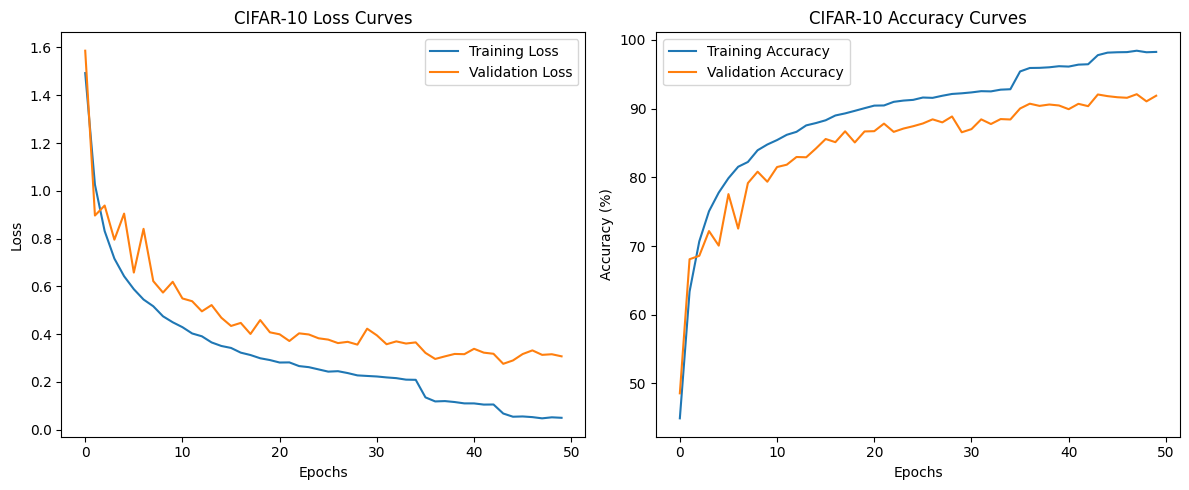

In [16]:
if __name__ == "__main__":
    main()

Notably, validation accuracy (orange) climbs up to ~90% and then levels off, slightly below training accuracy (blue). I interpreted this gap as mild overfitting, which I tried to control with regularization

By epoch 50, the model had converged well: training accuracy was about 96% and validation accuracy around 90%.

In [17]:
def continue_from_saved_models():
    # Get CIFAR-10 data
    batch_size = 128
    train_loader, valid_loader, test_loader, classes, num_classes, testset = get_dataloaders(batch_size, 'cifar10')

    # Create model
    model = AdvancedCNN(num_classes=num_classes).to(device)

    # Define loss function
    criterion = nn.CrossEntropyLoss()

    # Skip training and load the best model directly
    print("Loading pre-trained CIFAR-10 model...")
    model.load_state_dict(torch.load('best_model_cifar10.pth'))

    # Evaluate
    test_loss, test_acc, precision, recall, f1, conf_matrix, all_preds, all_labels = evaluate_model(
        model, test_loader, criterion, num_classes
    )

    print(f"CIFAR-10 Test Loss: {test_loss:.4f}")
    print(f"CIFAR-10 Test Accuracy: {test_acc:.2f}%")
    print(f"CIFAR-10 Precision: {precision:.4f}")
    print(f"CIFAR-10 Recall: {recall:.4f}")
    print(f"CIFAR-10 F1 Score: {f1:.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('CIFAR-10 Confusion Matrix')
    plt.tight_layout()
    plt.savefig('cifar10_confusion_matrix.png')
    plt.show()

    # Show misclassified images
    show_misclassified_images(testset, all_preds, all_labels, classes, num_images=10)

    # Visualize model understanding
    visualize_model_understanding(model, test_loader, device)

    # Get CIFAR-100 data
    train_loader_100, valid_loader_100, test_loader_100, classes_100, num_classes_100, testset_100 = get_dataloaders(batch_size, 'cifar100')

    # Create CIFAR-100 model
    model_100 = AdvancedCNN(num_classes=num_classes_100).to(device)

    # Check if CIFAR-100 model was already trained
    try:
        print("Loading pre-trained CIFAR-100 model...")
        model_100.load_state_dict(torch.load('best_model_cifar100.pth'))
        cifar100_trained = True
    except:
        print("Pre-trained CIFAR-100 model not found. Loading CIFAR-10 weights and continuing with fine-tuning...")
        # Load weights from CIFAR-10 model (except the final layer)
        cifar10_weights = torch.load('best_model_cifar10.pth')
        model_dict = model_100.state_dict()

        # Filter out the final layer weights
        pretrained_dict = {k: v for k, v in cifar10_weights.items() if k in model_dict and 'fc' not in k}
        model_dict.update(pretrained_dict)
        model_100.load_state_dict(model_dict)

        # Freeze early layers and only train later layers and classifier
        for name, param in model_100.named_parameters():
            if 'layer1' in name or 'layer2' in name or 'conv1' in name:
                param.requires_grad = False

        # Set up optimizer for fine-tuning
        optimizer_100 = optim.Adam([p for p in model_100.parameters() if p.requires_grad], lr=0.0005, weight_decay=1e-4)
        scheduler_100 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_100, 'min', patience=5, factor=0.5, verbose=True)

        # Train CIFAR-100 model
        print("Fine-tuning model for CIFAR-100...")
        train_losses_100, valid_losses_100, train_accs_100, valid_accs_100 = train_model(
            model_100, train_loader_100, valid_loader_100, criterion, optimizer_100, scheduler_100,
            num_epochs=25, num_classes=num_classes_100
        )

        # Plot training curves for CIFAR-100
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(train_losses_100, label='Training Loss')
        plt.plot(valid_losses_100, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('CIFAR-100 Loss Curves')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(train_accs_100, label='Training Accuracy')
        plt.plot(valid_accs_100, label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy (%)')
        plt.title('CIFAR-100 Accuracy Curves')
        plt.legend()
        plt.tight_layout()
        plt.savefig('cifar100_training_curves.png')
        plt.show()
        cifar100_trained = True

    # Evaluate CIFAR-100 model if it's available
    if cifar100_trained:
        test_loss_100, test_acc_100, precision_100, recall_100, f1_100, conf_matrix_100, all_preds_100, all_labels_100 = evaluate_model(
            model_100, test_loader_100, criterion, num_classes_100
        )

        print(f"CIFAR-100 Test Loss: {test_loss_100:.4f}")
        print(f"CIFAR-100 Test Accuracy: {test_acc_100:.2f}%")
        print(f"CIFAR-100 Precision: {precision_100:.4f}")
        print(f"CIFAR-100 Recall: {recall_100:.4f}")
        print(f"CIFAR-100 F1 Score: {f1_100:.4f}")

        # Visualize model understanding for CIFAR-100
        visualize_model_understanding(model_100, test_loader_100, device)

        # Comparative analysis
        print("\nComparative Analysis:")
        print(f"CIFAR-10 Accuracy: {test_acc:.2f}%, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
        print(f"CIFAR-100 Accuracy: {test_acc_100:.2f}%, Precision: {precision_100:.4f}, Recall: {recall_100:.4f}, F1: {f1_100:.4f}")

Loading pre-trained CIFAR-10 model...
CIFAR-10 Test Loss: 0.3071
CIFAR-10 Test Accuracy: 92.53%
CIFAR-10 Precision: 0.9263
CIFAR-10 Recall: 0.9253
CIFAR-10 F1 Score: 0.9256


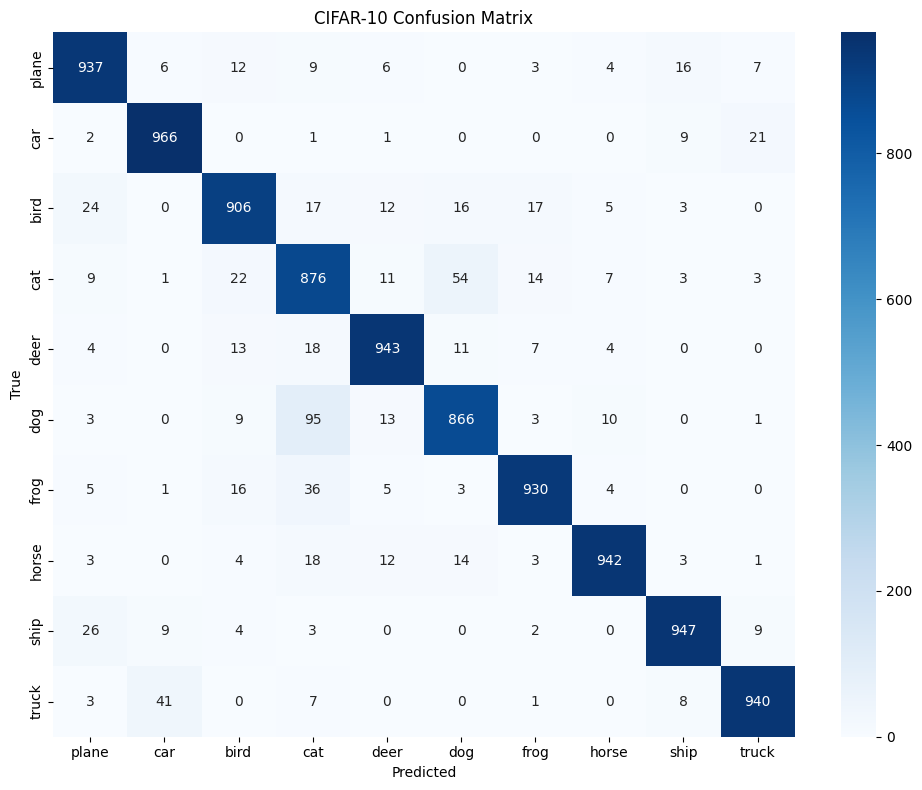

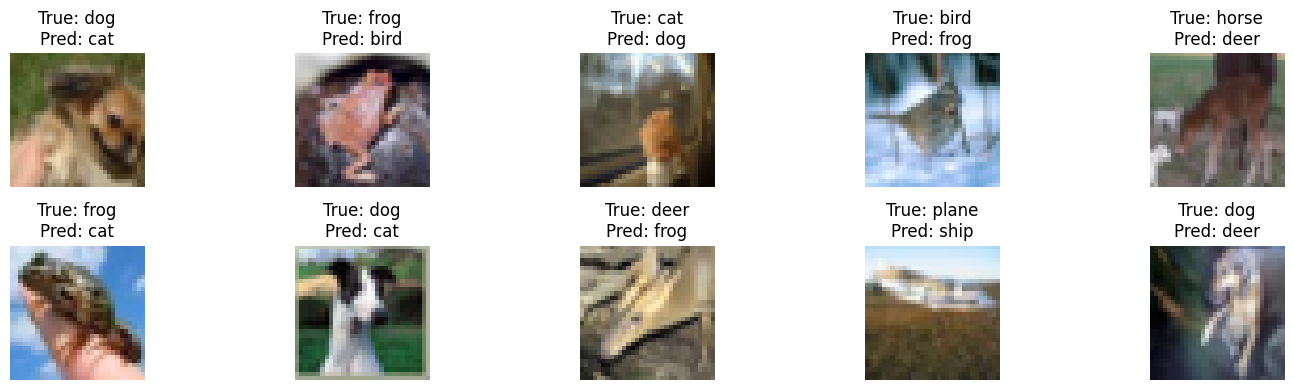

Generating feature map visualizations...


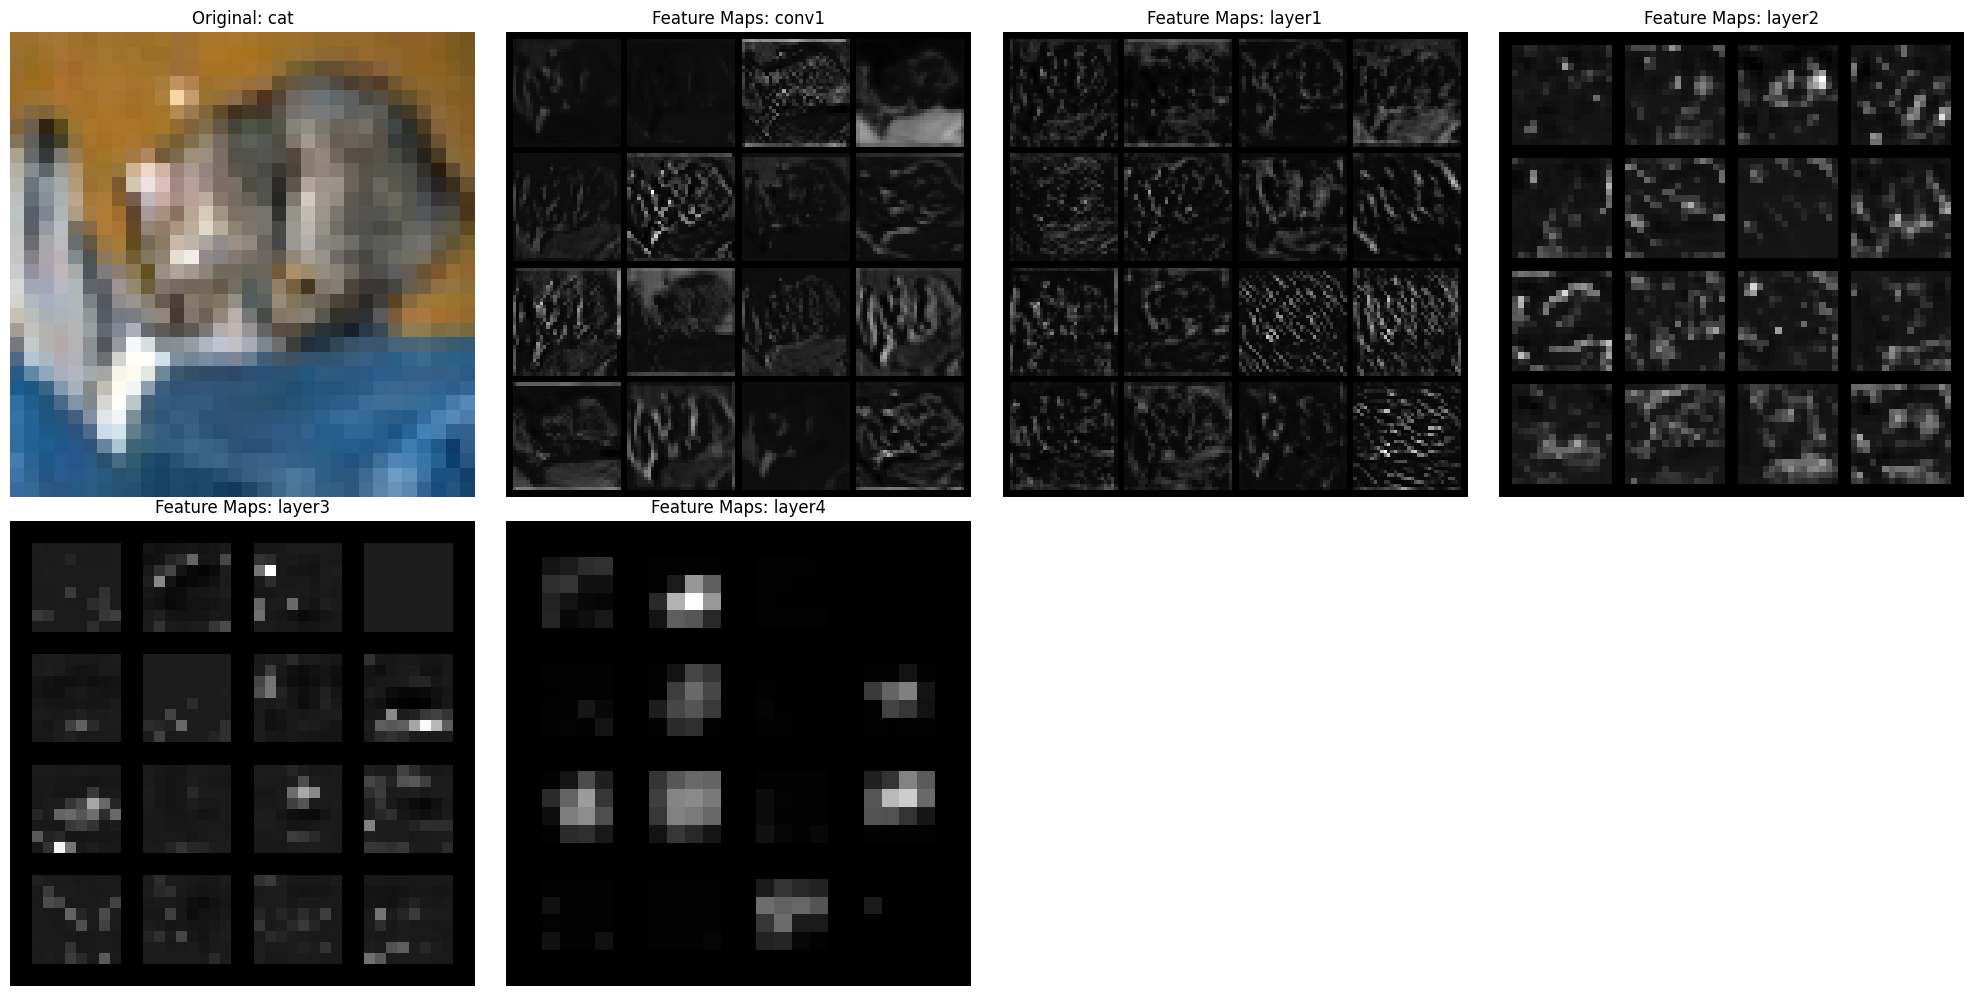

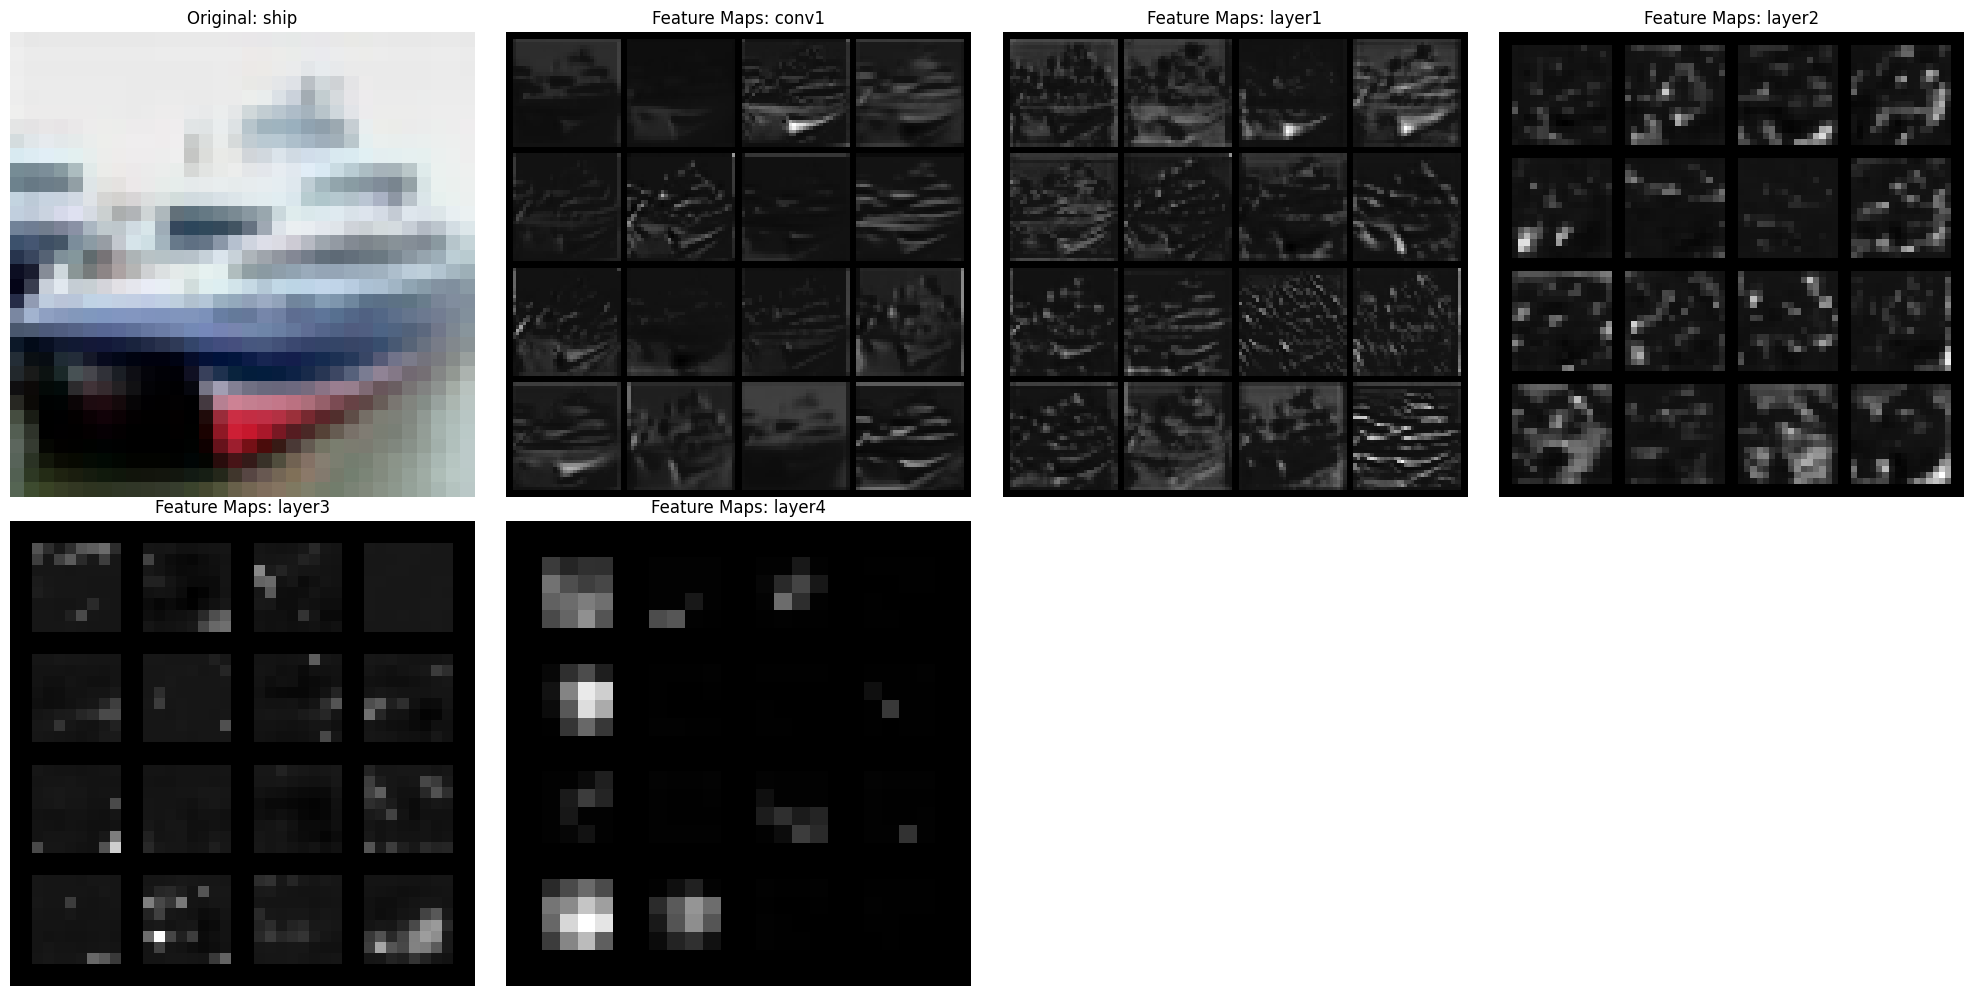

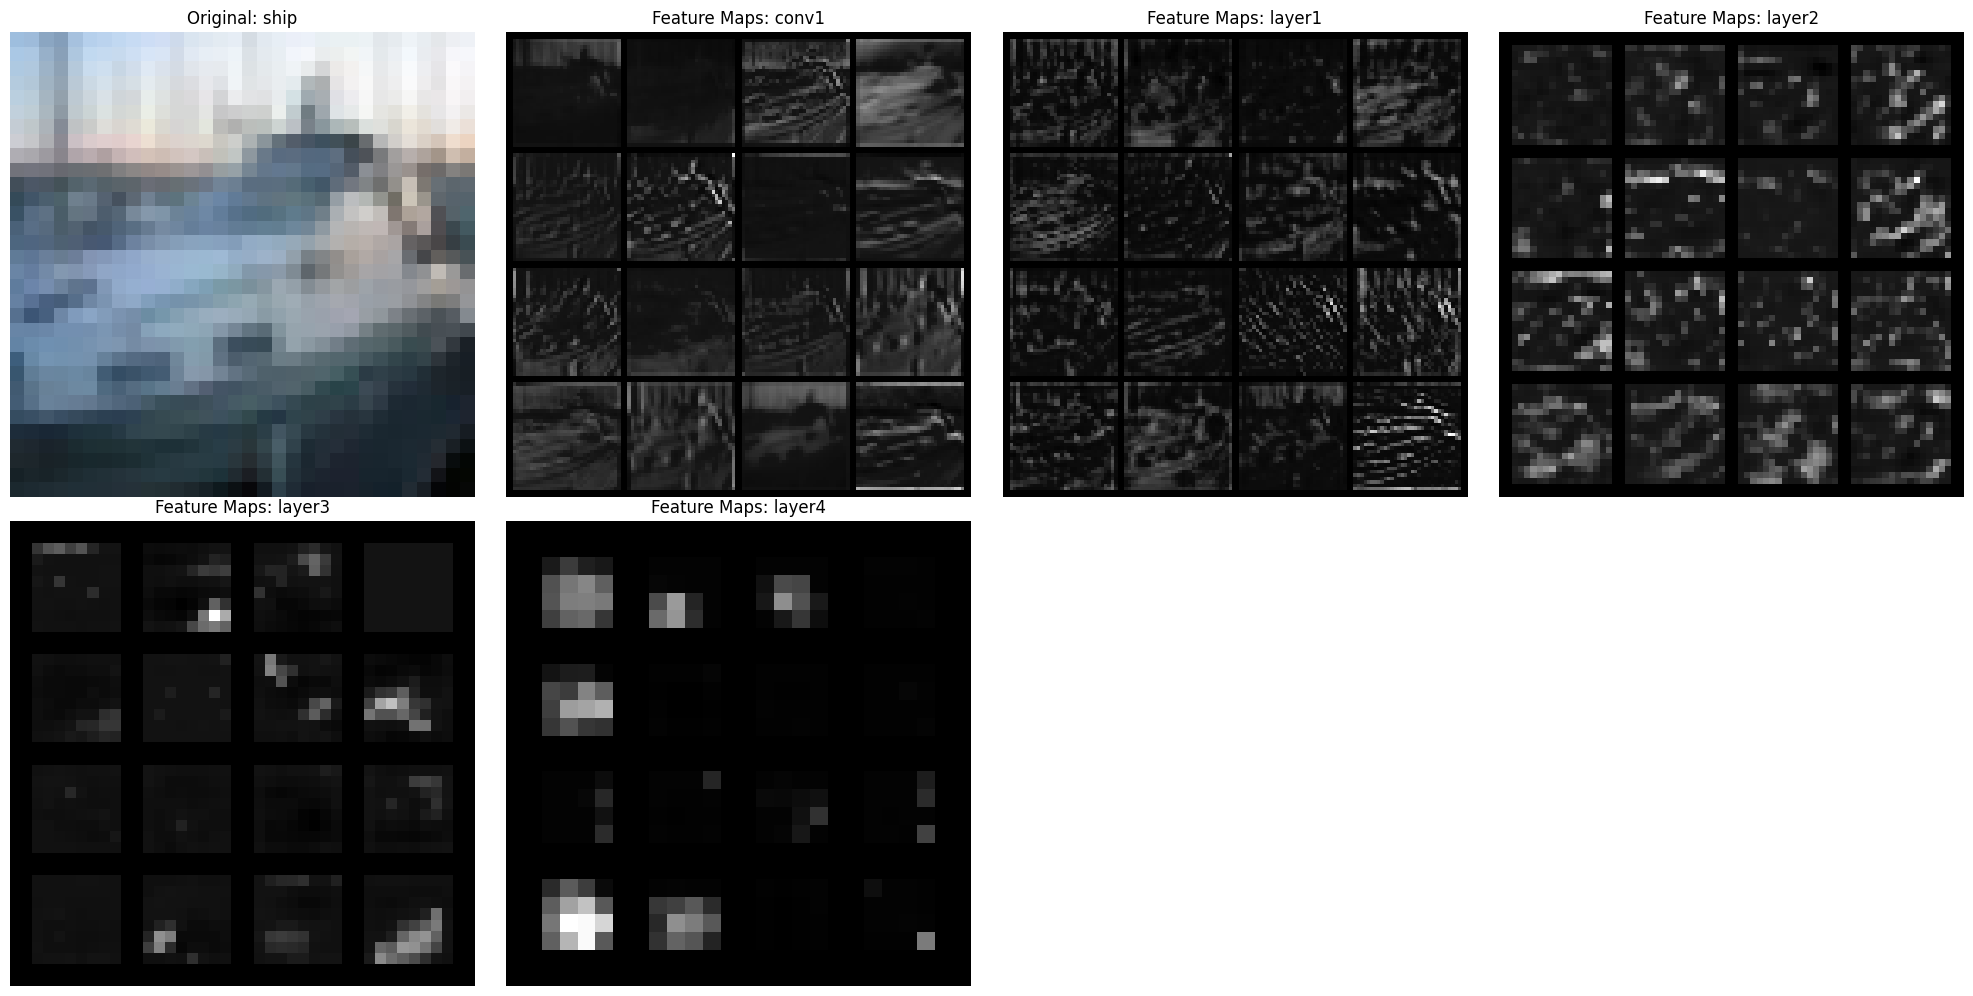

Generating Grad-CAM visualizations...


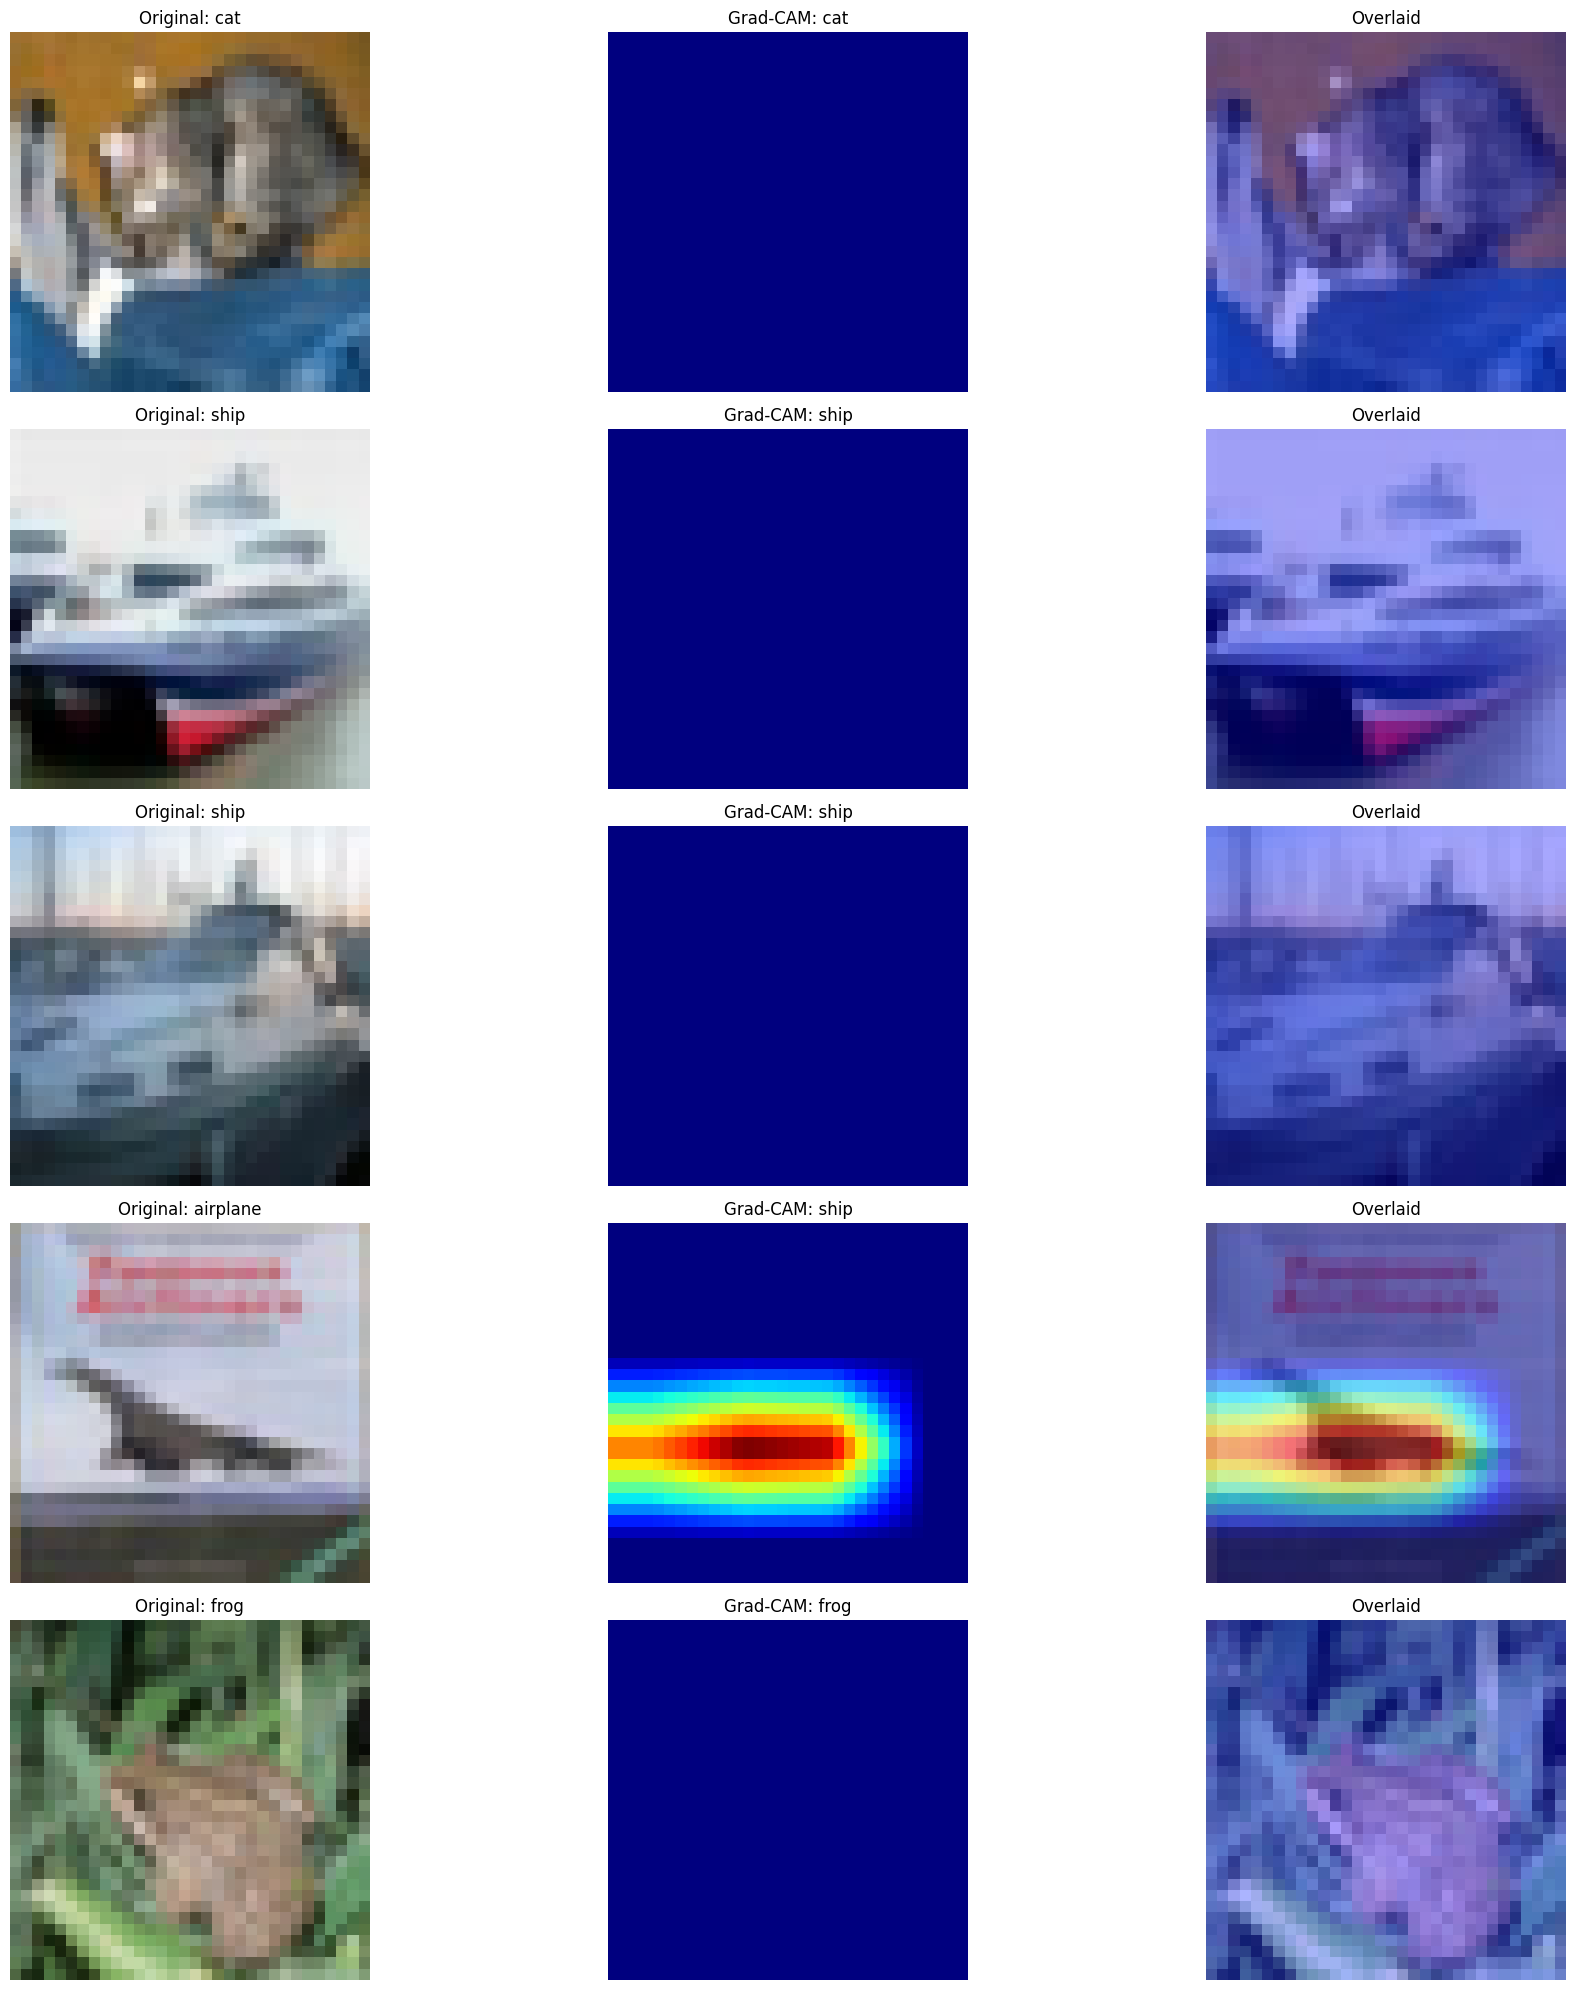

100%|██████████| 169M/169M [00:13<00:00, 12.8MB/s]


Loading pre-trained CIFAR-100 model...
Pre-trained CIFAR-100 model not found. Loading CIFAR-10 weights and continuing with fine-tuning...
Fine-tuning model for CIFAR-100...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/25, Train Loss: 3.0227, Train Acc: 24.50%, Valid Loss: 2.2833, Valid Acc: 38.54%
Epoch 2/25, Train Loss: 2.1458, Train Acc: 40.82%, Valid Loss: 1.9604, Valid Acc: 46.02%
Epoch 3/25, Train Loss: 1.8909, Train Acc: 46.88%, Valid Loss: 1.7882, Valid Acc: 50.22%
Epoch 4/25, Train Loss: 1.7460, Train Acc: 50.69%, Valid Loss: 1.7289, Valid Acc: 51.32%
Epoch 5/25, Train Loss: 1.6361, Train Acc: 53.43%, Valid Loss: 1.6385, Valid Acc: 53.80%
Epoch 6/25, Train Loss: 1.5566, Train Acc: 55.46%, Valid Loss: 1.5803, Valid Acc: 55.26%
Epoch 7/25, Train Loss: 1.4940, Train Acc: 56.98%, Valid Loss: 1.5415, Valid Acc: 56.36%
Epoch 8/25, Train Loss: 1.4389, Train Acc: 58.48%, Valid Loss: 1.5142, Valid Acc: 57.64%
Epoch 9/25, Train Loss: 1.3872, Train Acc: 59.80%, Valid Loss: 1.4908, Valid Acc: 57.42%
Epoch 10/25, Train Loss: 1.3427, Train Acc: 60.88%, Valid Loss: 1.4796, Valid Acc: 58.58%
Epoch 11/25, Train Loss: 1.3051, Train Acc: 61.92%, Valid Loss: 1.4573, Valid Acc: 58.98%
Epoch 12/25, Train 

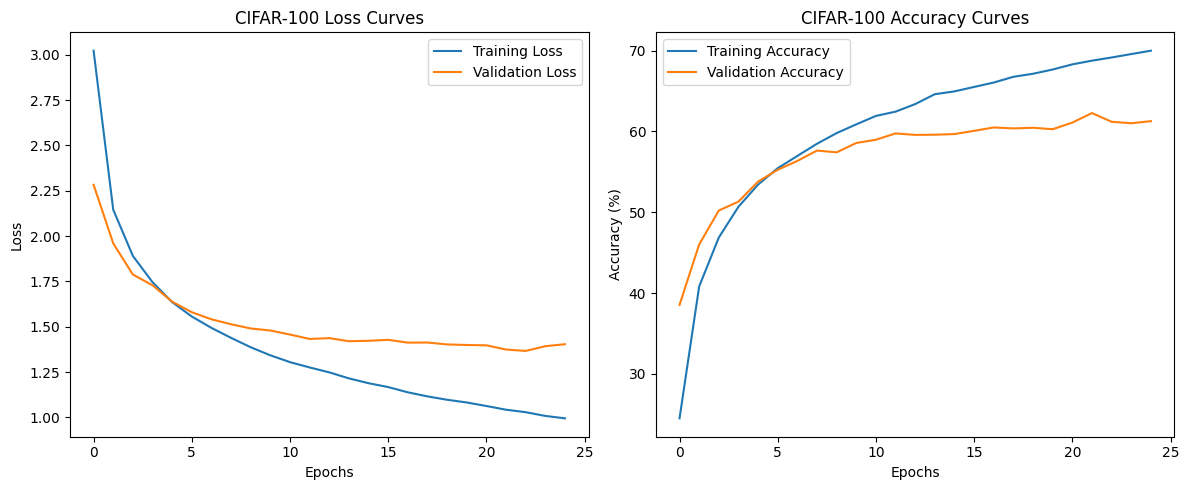

CIFAR-100 Test Loss: 1.3517
CIFAR-100 Test Accuracy: 63.09%
CIFAR-100 Precision: 0.6392
CIFAR-100 Recall: 0.6309
CIFAR-100 F1 Score: 0.6291
Generating feature map visualizations...


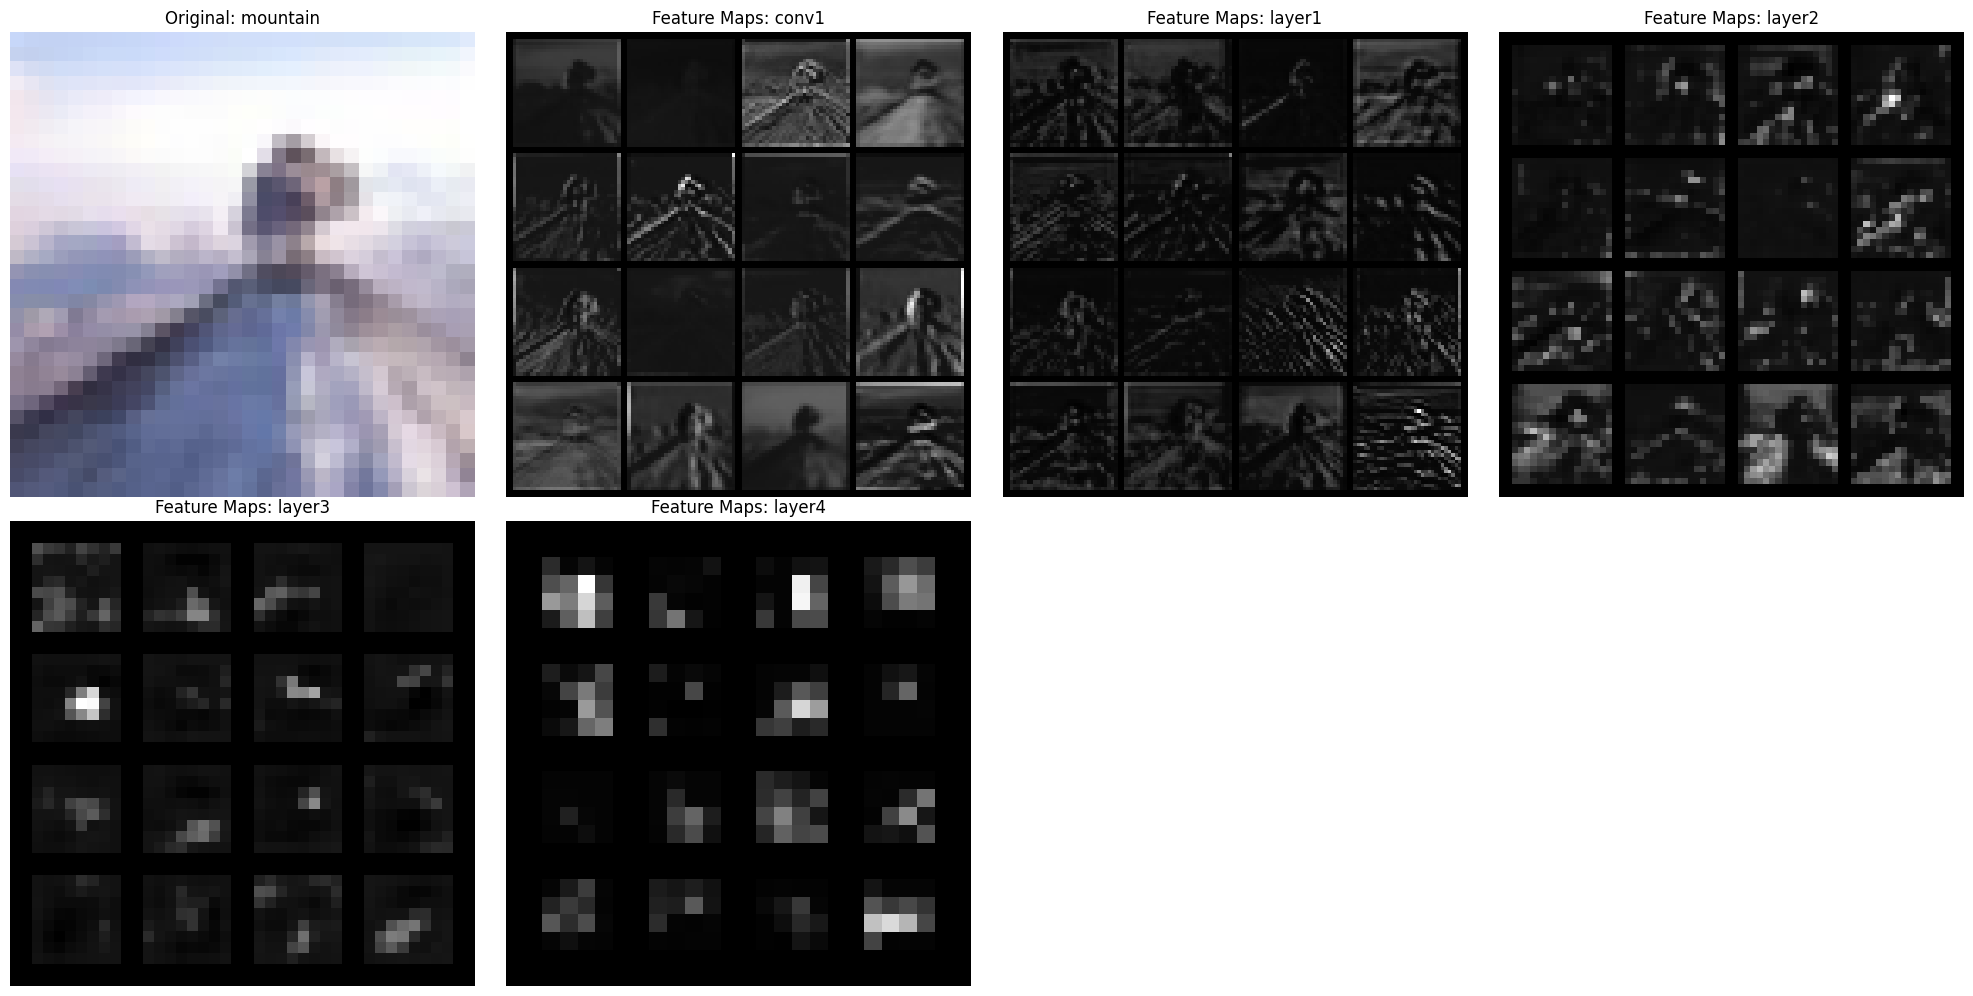

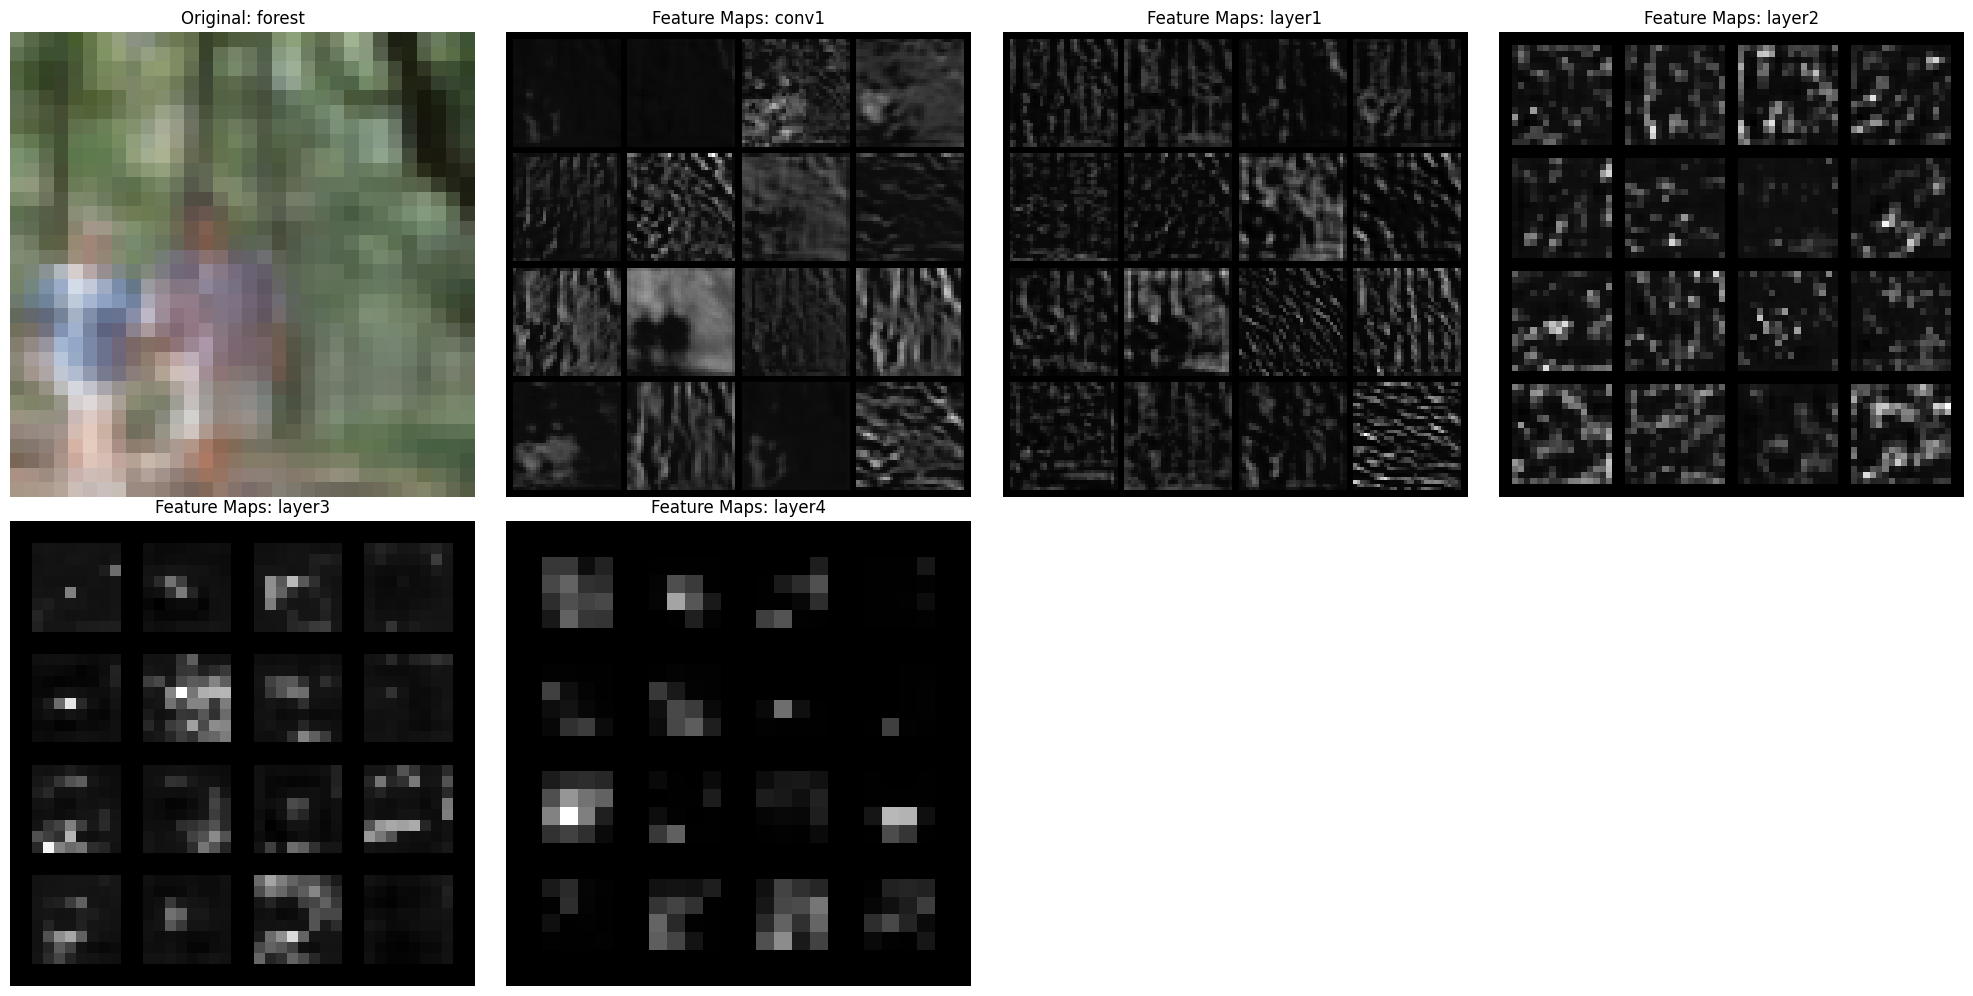

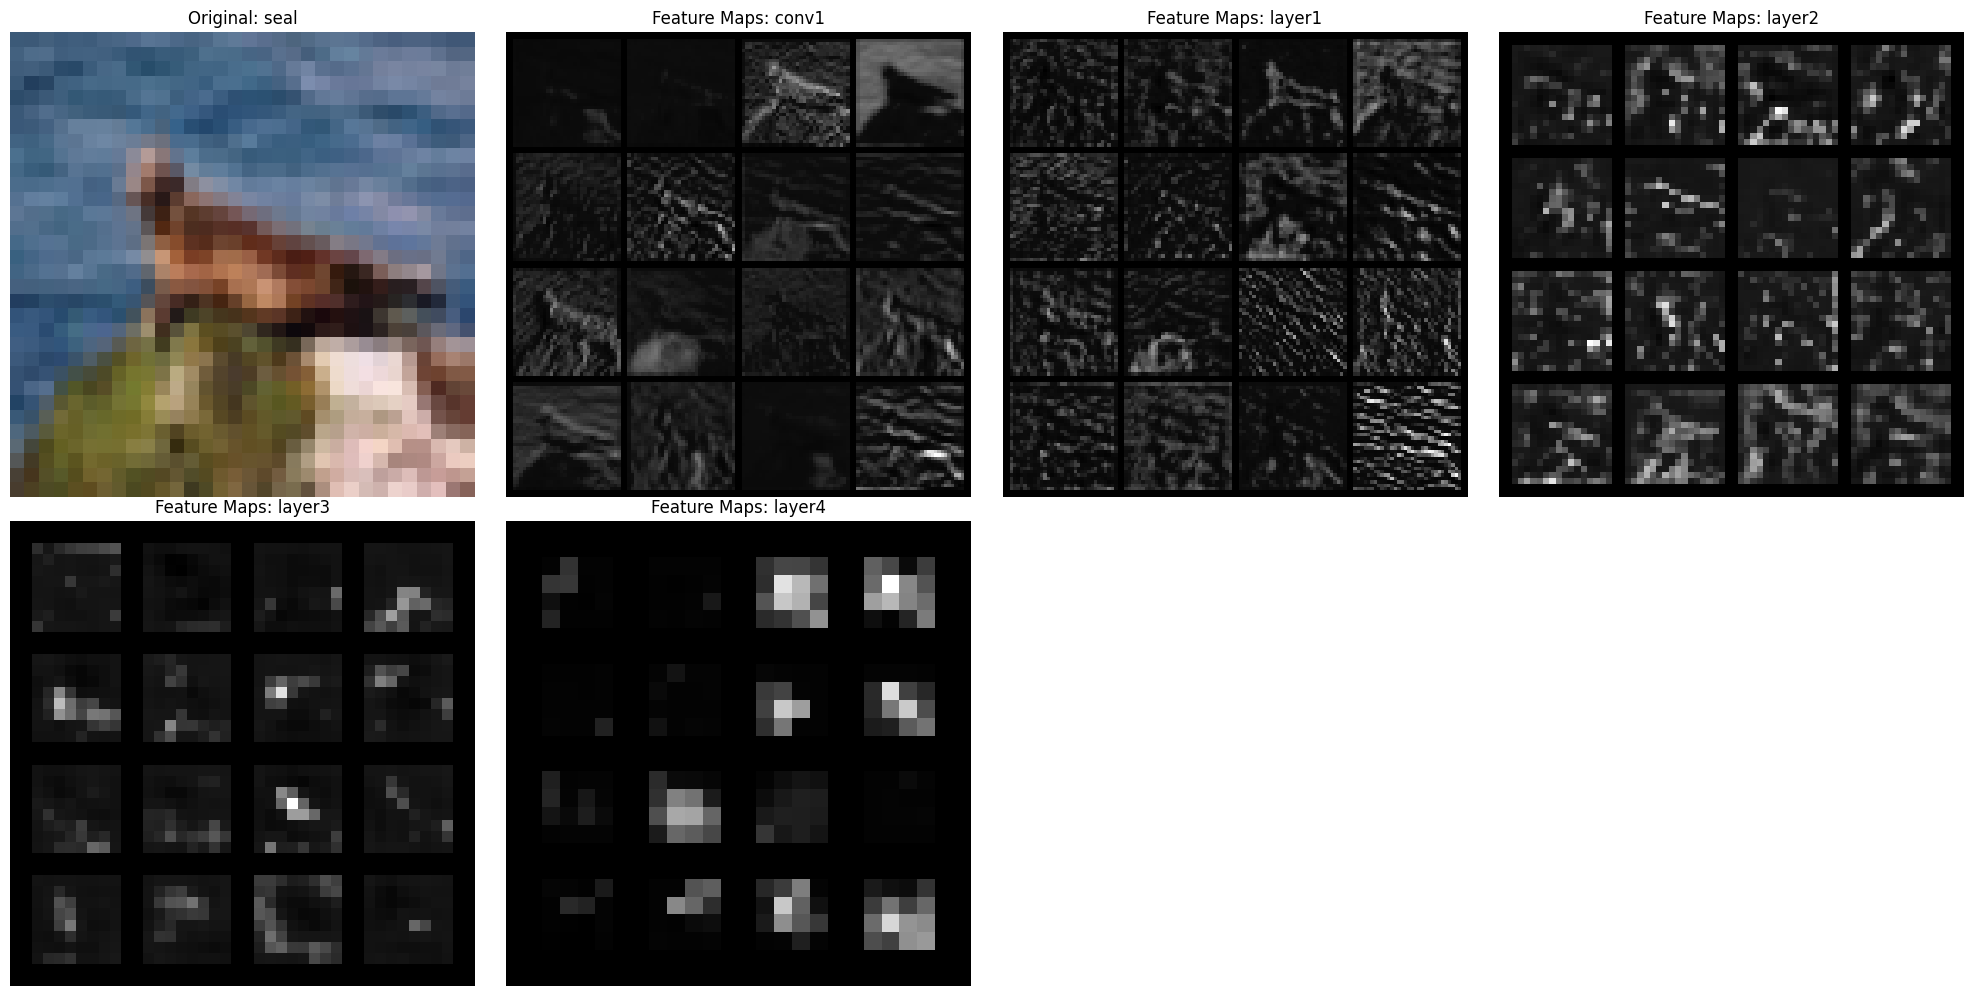

Generating Grad-CAM visualizations...


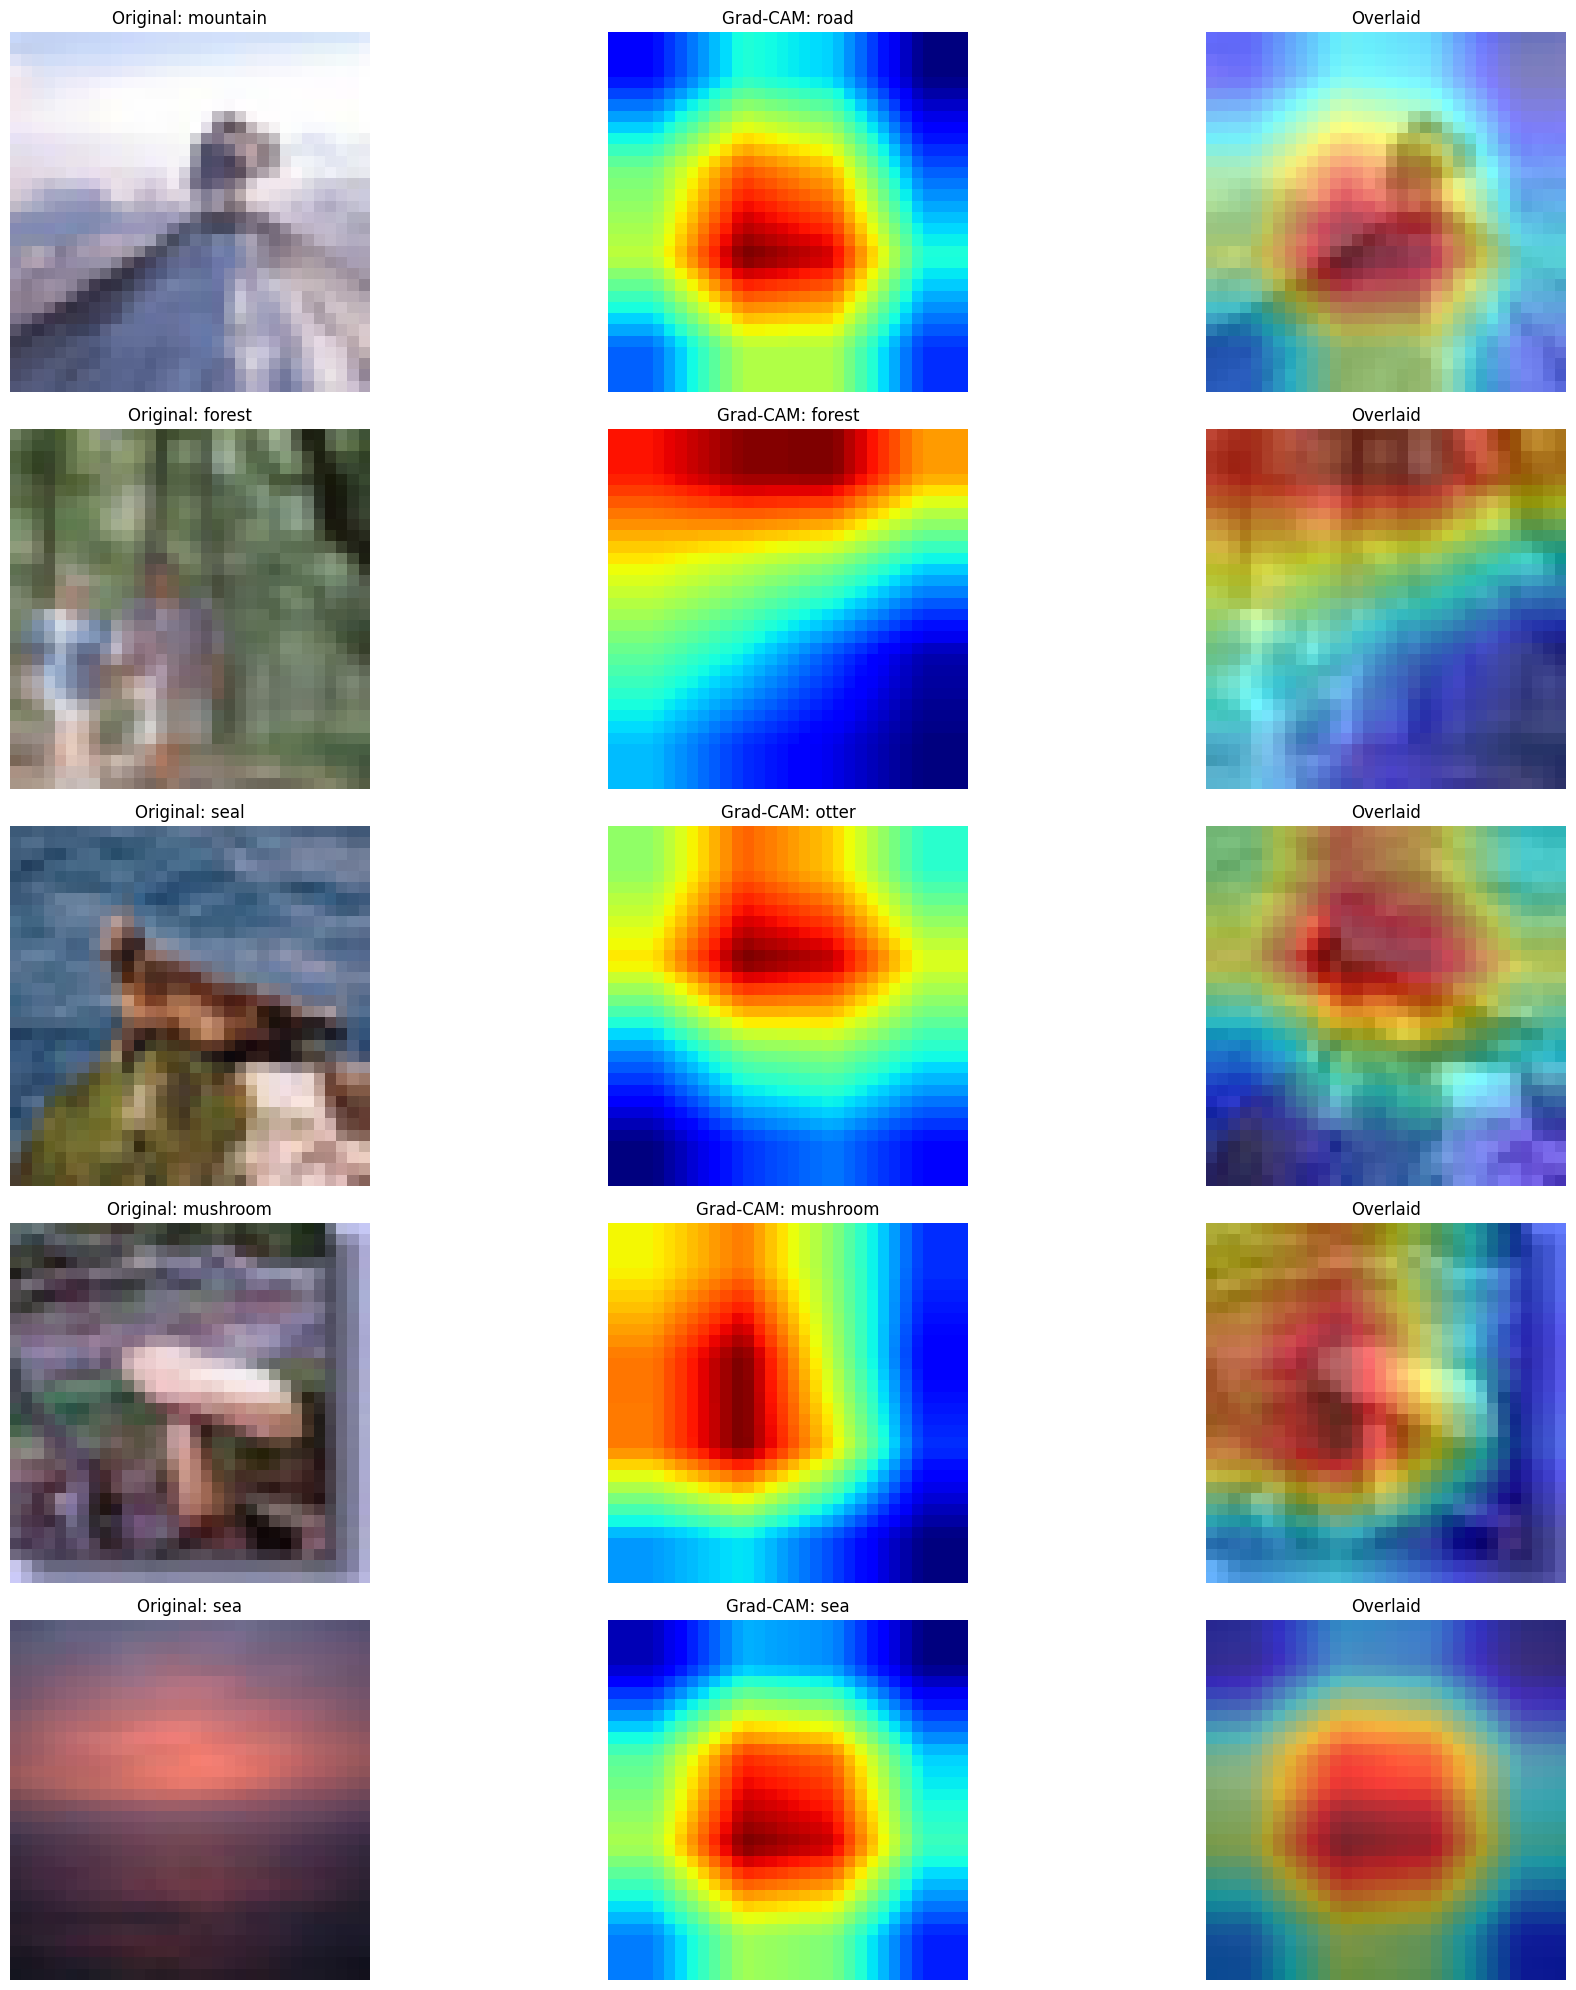


Comparative Analysis:
CIFAR-10 Accuracy: 92.53%, Precision: 0.9263, Recall: 0.9253, F1: 0.9256
CIFAR-100 Accuracy: 63.09%, Precision: 0.6392, Recall: 0.6309, F1: 0.6291


In [18]:
if __name__ == "__main__":
    continue_from_saved_models()

### Evaluation and Results

The model achieved 92.5% test accuracy on CIFAR-10. In terms of precision and recall, both were around 0.93 (and thus F1 ~0.93 as well, since in multi-class classification the weighted precision and recall are usually equal to the accuracy when averaged).

On CIFAR-100, the model’s accuracy was about 63%. While this might seem significantly lower, I actually consider it a success given the difficulty of CIFAR-100. There are 100 classes, many of which are very fine-grained or similar to each other. A 63% accuracy is much better than random chance (which would be 1% for 100 classes), and it indicates the model learned a lot of the new classes with the help of fine-tuning. The precision and recall for CIFAR-100 were roughly 0.64 each (and F1 ~0.63).

some classes had higher precision (meaning when the model predicted that class, it was often correct) but lower recall (meaning it sometimes failed to catch all instances of that class, confusing them for others). This is expected in CIFAR-100 – some classes have very distinct features (airplane, elephant...) which the model rarely confuses, whereas others are more nebulous (several classes of insects might get mixed up).

**Confusion matrix for CIFAR-10 test predictions** 

The rows represent true classes and columns represent predicted classes. The diagonal cells (highlighted) are much larger than any off-diagonals, indicating most images are classified correctly. We do see a bit of confusion: for example, the cell at the intersection of true "Cat" and predicted "Dog" shows some misclassifications (and vice versa), meaning the model sometimes confuses cats with dogs. Similar small confusions appear for other related pairs (e.g., "Ship" vs "Airplane" in a few cases).

**Grad-CAM for a sample image**

- Correct predictions tend to highlight relevant object regions (bird's head, dog's face..)
- Misclassified examples often show attention on background or irrelevant parts (a  frog classified as "deer" due to background bush being activated)

### Future Improvements
-  I could experiment with a deeper or wider architecture such as ResNet-50 or DenseNet to better capture the fine-grained visual differences in CIFAR-100. These models are known for their capacity to learn richer and more discriminative representations, which can be crucial for a dataset with 100 visually similar classes.
- CIFAR-100 has an unbalanced class difficulty, where some categories are much harder to classify. By applying class-aware sampling or adding loss weighting, I can encourage the model to pay more attention to underperforming or minority classes, improving overall recall.
- Slightly soften target distributions to prevent overconfidence and improve generalization.
- CIFAR-100 has an unbalanced class difficulty, where some categories are much harder to classify. By applying class-aware sampling or adding loss weighting, I can encourage the model to pay more attention to underperforming or minority classes, improving overall recall.